In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import os, glob
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import datetime as dt
import gc
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from shapely.geometry import Polygon, LineString, Point
import shapely.geometry as ss
import matplotlib.pyplot as plt

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def find_nearest_idx(array, value):
    # Encuentra la posición  más cercano en un array 1D
    #array = np.asarray(array)
    idx = np.argmin(np.abs(array - value))
    return idx

def find_nearest_idx_time(array, value):
    # Encuentra la posición  más cercano en un array 1D
    if value >= array[0] and value <= array[-1]:
        idx = np.argmin(np.abs(array - value))
        return idx
    return np.nan


def save_nc_from_pkl(dictionary, file_out):
    dictionary['lon_traj']      = dictionary['lon_traj'][0]
    dictionary['datetime_traj'] = dictionary['datetime_traj'][0]
    dictionary['plev_traj']     = dictionary['plev_traj'][0]
    dictionary['lat_traj']      = dictionary['lat_traj'][0]
    save_nc(dictionary=dictionary, file_out=file_out)
       
def save_nc(dictionary, file_out):
    # Se crea un vector de las fechas
    dates_vector = dictionary['datetime_traj'].reshape(-1)
    [dates_dim, back_step_dim] = dictionary['lon_traj'].shape
    
    # Time reference
    time_ref = '1900-01-01 00:00:00'
    date_ref = pd.to_datetime(time_ref)
    
    
    # Se obtiene el vector de fechas en segundos
    dates = np.zeros_like(dates_vector)*np.nan
    for i, date_i in enumerate(dates_vector):
        try:
            dates[i] = int((date_i - date_ref).total_seconds()/3600)
        except: pass
    
    # Se define la referencia temporal
    ncvar_time_units   = f'hours since {time_ref}'
    ncvar_time_long_name = f'hours since {time_ref}, '\
        f'Reshape vector as {dates_dim}x{back_step_dim}'

    # def save_nc(dictionary, file_out):
    nw = Dataset(file_out, 'w', format='NETCDF4')
    
    dates_vector = dates_dim*back_step_dim
    
    # Definir dimensiones
    nw.createDimension('time_bt',  dates_dim)
    nw.createDimension('back_step', back_step_dim)
    nw.createDimension('time_vector', dates_vector)
    
    # Se crean las variables
    ncvar_time  = nw.createVariable('time', 'f', ('time_vector'))
    ncvar_lat   = nw.createVariable('lat',  'f', ('time_bt','back_step'))
    ncvar_lon   = nw.createVariable('lon',  'f', ('time_bt','back_step'))
    ncvar_plev  = nw.createVariable('level','f', ('time_bt', 'back_step'))

    # Agregar atributos
    ncvar_lat.units  = 'degrees_north'
    ncvar_lon.units  = 'degrees_east'
    ncvar_plev.units = 'hPa'
    ncvar_time.units = ncvar_time_units

    ncvar_plev.long_name =  'Level'
    ncvar_lon.long_name   = 'Longitude'
    ncvar_lat.long_name   = 'Latitude'
    ncvar_time.long_name  = ncvar_time_long_name

    # writing variables in netCDF file
    ncvar_time[:]   = dates
    ncvar_plev[:]   = dictionary['plev_traj']
    ncvar_lon[:]    = dictionary['lon_traj']
    ncvar_lat[:]    = dictionary['lat_traj']

    nw.close()    
    del(nw)


def Follow(path=None, path_fig=None, source='GFS',
             lati=6.25,loni=-75.6, warnings=False):
    
    source = source.upper()
    # Safety precautions
    #             'CMIP6':{'lat'  : 'lat',  # Hace falta revisar estos archivos
    #                     'lon'   : 'lon',
    #                     'level' : 'level',
    #                     'uwnd'  : 'ua',
    #                     'vwnd'  : 'va',
    #                     'omega' : 'wap'}}

   
    if path == None:
        print('Advertencia: No se ha especificado la ruta de los archivos')
        
    if path_fig == None:
        if warnings:
            print('Advertencia: No se ha especificado la ruta '\
                          'para almacenar las gráficas')
            
    if (source == 'GFS') and (path != None):
        
        # Ideantificamos la ruta de los archivos .grib
        files_list = np.sort([y for x in os.walk(path) for y \
                  in glob.glob(path+"*t00*.nc")])

        if len(files_list) != 0:                
            # Se extraen las fechas apartir del nombre de cada archivo
            files_date = pd.to_datetime([i.split('/')[-1]\
                            [-13:-len('.nc')] \
                            for i in files_list],format='%Y%m%d%H')

            # Dataset properties
#             print(f'\nCargando propiedades del objeto de:\n\t{files_list[0]}')
            Variable = xr.open_dataset(files_list[0])
            
            lat_dataset = Variable.variables['latitude'].data
            lon_dataset = Variable.variables['longitude'].data
            levels_dataset  = Variable.variables['isobaricInhPa'].data
            del(Variable)
            gc.collect()
            return files_date, files_list, lat_dataset, \
                            lon_dataset, levels_dataset
    
        else:
            print(f'Advertencia: No hay archivos de entrada en {path}')
            
            
def Trajectories_level_i(lati,loni,leveli,Fechai, Fechaf, delta_t,
                         ndays,source,path_files,
                        files_date=None, files_list=None, lat_dataset=None, lon_dataset=None, levels_dataset=None):
    
    if Fechai != None and Fechaf != None:
        Fechai = pd.to_datetime(Fechai)
        Fechaf = pd.to_datetime(Fechaf)
    else:
        print('Advertencia: Debe espeficicar las fechas')


    datetimes_iter = pd.date_range(Fechai,Fechaf,
                                        freq=f'{delta_t}H')        
    print(datetimes_iter)
    '''
    Apartar el espacio para las BT
    ----------------------------------------------------------------------    
    dates_dim:      dimensión son las fechas a partir de las cuales se van
                    a calcular las trayectorias
    back_step_dim:  dimensión longitud temporal de cada retrotrayectoria
    '''
    [dates_dim, back_step_dim] = [len(datetimes_iter), \
                                  int((24/delta_t)*ndays+1)]

    BT = {}
    BT['lat_traj']  = np.zeros([dates_dim, back_step_dim])
    BT['lon_traj']  = np.zeros([dates_dim, back_step_dim])
    BT['plev_traj'] = np.zeros([dates_dim, back_step_dim])
    BT['datetime_traj'] = \
            np.zeros([dates_dim, back_step_dim]).astype(object)
    BT['steps_traj'] = np.zeros([dates_dim, back_step_dim])
    
    print ('Computing BT:')
    print('-'*85)

    print (f'\t{int(leveli)}hPa')


    for di,dti in enumerate(datetimes_iter):
        print(dti)
        BT['lat_traj'][di,:], \
            BT['lon_traj'][di,:],\
            BT['plev_traj'][di,:], \
            BT['datetime_traj'][di,:],\
            BT['steps_traj'][di,:] = \
                compute_BT(datetime0=dti,lat0=lati,lon0=loni,plev0=leveli, 
                           ndays=ndays, delta_t=delta_t,source=source,path_files=path_files,
                           files_date=files_date, files_list=files_list, lat_dataset=lat_dataset, 
                           lon_dataset=lon_dataset, levels_dataset=levels_dataset)
    return BT             
                    
def compute_BT(datetime0,lat0,
                        lon0,plev0, ndays, delta_t,path_files, source,
              files_date=None, files_list=None, lat_dataset=None, lon_dataset=None, levels_dataset=None):
    '''
    plev0: [hPa] pressure level_i for the calculation
    datetime0: datetime_i for the calculation
    delta_t: [h] máximo 4 días
    lat0, lon0: [degree] initial coordenates for the calculation
    '''
    print("soy el datetime0 que le entra a compute_BT", datetime0)

    if ((files_date.to_list()==None)&(list(files_list)==None)):
        files_date, files_list, lat_dataset, lon_dataset, levels_dataset = \
                 Follow(path=path_files, path_fig=None, source=source,warnings=False)
    # Se caculan las velocidades aproximadas u,v,omega
    # para el datetime0 y plev0        
    if source == 'GFS':
        u0,v0,w0 = data_from_xr(plev0,datetime0,lat0,lon0,files_list,files_date,lat_dataset,lon_dataset,levels_dataset)

    N_hours_back  = int(ndays*24)
    Dim_iteration = int(ndays*24/delta_t)+1
    
    # Se separa el espacio para almacenar la información
    lat_traj   = np.zeros(Dim_iteration)*np.nan
    lon_traj   = np.zeros(Dim_iteration)*np.nan
    plev_traj  = np.zeros(Dim_iteration)*np.nan        
    steps_traj = np.zeros(Dim_iteration)*np.nan
    datetime_traj = np.zeros(Dim_iteration).astype(object)*np.nan

    # Para el primer paso de tiempo las coordenadas son las iniciales
    lat_traj[0]   = lat0
    lon_traj[0]   = lon0
    plev_traj[0]  = plev0       
    steps_traj[0] = 0
    datetime_traj[0] = datetime0

    # Se crean variables para almacenar temporalmente la información
    lon_temp  = lon0
    lat_temp  = lat0
    plev_temp = plev0
    datetime_temp = datetime0
    u_temp = u0
    v_temp = v0
    w_temp = w0
    
    
    for ii, steps_back in enumerate(range(delta_t,(N_hours_back)+1,\
                                          delta_t), start=1):
        # Se calcula la posicón espacial para el siguiente paso de tiempo
        #       X(t_1) = X(t_0)+(delta_t)*V(t_0)
        lat_temp, lon_temp, plev_temp = \
                    compute_location(lat0=lat_temp,lon0=lon_temp,
                            plev0=plev_temp,u=u_temp,v=v_temp,w=w_temp,
                            delta_t=delta_t)

        datetime_temp = datetime_temp - pd.Timedelta(f"{delta_t}h")
        
        # Permitir que se sigan calculando las trayectorias
        if lon_temp < -180:
            lon_temp += 360
        if lon_temp > 180:
            lon_temp -= 360
        
        # Se recalculan las componentes de velocidad para la siguiente iteración
        
        if source == 'ERA5':
            u_temp,v_temp,w_temp = \
                data_from_xr(plev_temp,datetime_temp,lat_temp,lon_temp,files_list,files_date,lat_dataset,lon_dataset,levels_dataset)
        if source == 'GFS':
            u_temp,v_temp,w_temp = \
                data_from_xr(plev_temp,datetime_temp,lat_temp,lon_temp,files_list,files_date,lat_dataset,lon_dataset,levels_dataset)
                
        if source == 'ERA2':
            u_temp,v_temp,w_temp = data_from_nc(plev_temp,datetime_temp,
                                               lat_temp,lon_temp,files_list,files_date,lat_dataset,lon_dataset,levels_dataset)
        
        # Si no se trata de un dato de tiempo que no esté:
        if np.isnan(u_temp): 
            #print(f'\t\t\t\tFecha no disponible: {datetime_temp}')
            break
            
        if ((lon_temp > np.nanmax(lon_dataset))  | \
            (lon_temp < np.nanmin(lon_dataset))): break

        if ((lat_temp > np.nanmax(lat_dataset))  | \
            (lat_temp < np.nanmin(lat_dataset))): break


        else:
            lat_traj[ii]   = lat_temp
            lon_traj[ii]   = lon_temp
            plev_traj[ii]  = plev_temp           
            steps_traj[ii] = steps_back
            datetime_traj[ii] = datetime_temp
    return  lat_traj, lon_traj, plev_traj,\
                datetime_traj, steps_traj
                


def compute_location(lat0,lon0,plev0,u,v,w,delta_t,BT=True):
    '''
    The ‘zero acceleration’ solution to the differential trajectory equation
        X(t_1) = X(t_0)+(delta_t)*V(t_0)


    u,v:     m/s
    omega:   Pascales/s
    delta_t: horas
    '''

    
    
    # Forward Trajectories
    dx = u*delta_t*60*60       # meters
    dy = v*delta_t*60*60       # meters
    dz = (w/100)*delta_t*60*60 # hPa
    
    plev = plev0+(-dz if BT else dz)
    r_earth = 6378000
    if BT:
        # Transformando metros a grados
        new_latitude  = lat0 - (dy / r_earth) * (180 / np.pi)
        new_longitude = lon0 - (dx / r_earth) * (180 / np.pi) \
                                                / np.cos(lat0 * np.pi/180)
    else:
        new_latitude  = lat0 + (dy / r_earth) * (180 / np.pi)
        new_longitude = lon0 + (dx / r_earth) * (180 / np.pi) \
                                                / np.cos(lat0 * np.pi/180)
    if plev>1000:
        plev = 1000
    return new_latitude, new_longitude, plev


def data_from_xr(level,dti,lati,loni,files_list,files_date,lat_dataset,lon_dataset,levels_dataset):
    
    '''
    Retorna la velocidad u,v,omega de un punto x,y,z (loni, lati, level)
    para una fecha (dti) determinada
    '''
    
    
    # Leo el viento que necesito del netcdf y determino el índice
#     print(files_date)
#     print(dti)
#     pos_date  = find_nearest_idx_time(files_date,dti)
    pos_date  = find_nearest_idx(files_date,pd.to_datetime(dti))
    if dti.hour in [22,16,10,4]:
#         print("hora rara: ", dti.hour)
        pos_date = pos_date-1
#         print(pos_date)
#     print(files_list[pos_date])
    
    v = xr.open_dataset(files_list[pos_date])["v"]
    hour_dataset = np.array(v['time'].dt.time)
    hour_dataset = np.array([i.hour for i in hour_dataset])
    #hour_dataset
    # Si la fecha leida esta por fuera del rango disponible
    #if jnp.isnan(pos_date): return np.nan,np.nan,np.nan
    
#     print(level,dti,lati,loni)
    pos_lat   = find_nearest_idx(lat_dataset,lati)
    pos_lon   = find_nearest_idx(lon_dataset,loni)
    pos_level = find_nearest_idx(levels_dataset,level)
    pos_hora = find_nearest_idx(hour_dataset,dti.hour)
    
    if dti.hour == 23:
        pos_hora = 0 
#     print("archivo leído: ", files_list[pos_date])
#     print("hora leída: ", hour_dataset[pos_hora])
    # # Tener en cuenta el keyword de la fuente de datos
    # u = Variable.variables['u'].data[pos_level,pos_lat,pos_lon]
    # v = Variable.variables['v'].data[pos_level,pos_lat,pos_lon]
    # omega = Variable.variables['w'].data[pos_level,pos_lat,pos_lon]
    # Variable.close()
    
    v = xr.open_dataset(files_list[pos_date])["v"]\
            [pos_hora, pos_level,pos_lat,pos_lon]
    vv = float(v.values)
    del(v)
    u = xr.open_dataset(files_list[pos_date])["u"]\
            [pos_hora, pos_level,pos_lat,pos_lon]
    uu = float(u.values)
    del(u)
    omega = xr.open_dataset(files_list[pos_date])["w"]\
            [pos_hora, pos_level,pos_lat,pos_lon]
    ww = float(omega.values)
    del(omega)
    gc.collect()
    return uu, vv, ww


def Plot_Trajectories(BT, *args,**kwargs):
    
    figsize    = kwargs.get('figsize',(10,10))
    img_extent = kwargs.get('img_extent',(-90,-10, -30, 20))

    plt.close('all')

    fig = plt.figure(figsize=figsize)

    plt.rcParams['axes.spines.top']    = False
    plt.rcParams['axes.spines.bottom'] = False
    plt.rcParams['axes.spines.left']   = False
    plt.rcParams['axes.spines.right']  = False

    ax = plt.subplot(1,1,1,projection=ccrs.PlateCarree())
    ax.set_extent(img_extent, ccrs.PlateCarree())

    #ax.stock_img()
    #ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.OCEAN,alpha=0.2)
    ax.add_feature(cartopy.feature.LAND, color = 'silver', alpha=0.2);


    ax.coastlines(resolution='10m', color='k', linewidth=0.5) 
    ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='k',
            linewidth=0.5)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
              linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False

    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'color': 'gray', 'size':12}
    gl.ylabel_style = {'color': 'gray', 'size':12}
    
    
    [dates_dim, back_step_dim] = BT['lon_traj'].shape
    for di in range(dates_dim):
        ax.plot(BT['lon_traj'][di,:], 
                BT['lat_traj'][di,:])

    return fig,ax

def read_nc(file_i):
    """Función que lee los archivos donde se almacenan las BT
    diarias y devuelve cada componente"""
    print(file_i)
    Variable = Dataset(file_i,'r')

    dates  = np.array(Variable.variables['time'][:])

    fechas = pd.to_datetime("1900-01-01 00:00:00") \
                    + pd.to_timedelta(dates, unit='h')

    lon_values = np.array(Variable.variables['lon'][:])
    lat_values = np.array(Variable.variables['lat'][:])
    plev_values = np.array(Variable.variables['level'][:]) #shape 24x241
    fechas = np.array(fechas).reshape(plev_values.shape)
    
    return fechas, plev_values, lat_values, lon_values

def meters_to_degrees(meters):
    r_earth = 6378000  ##Radio de la tierra en meters
    return ((meters *180) / (r_earth*np.pi))

def search_fire(lon,lat, poligono):
    """saber si un punto x,y está o no dentro de un polygon"""
    aa = ss.Point([lon,lat])
    return poligono.contains(aa)



In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import os, glob
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xrc
import datetime as dt
import gc
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from shapely.geometry import Polygon, LineString, Point
import shapely.geometry as ss
import matplotlib.pyplot as plt

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import sys

lati =   6.25
loni = -75.60

# Propiedades del cálculo
delta_t = 1  # horas
leveli  = 800 # hPa    

source = 'GFS'

path_files = '/var/meteo/GFS/processed/'
path_out   = '/var/meteo/GFS/BT/'

ndays = 5

# Variables extraidas de los datos
files_date_2, files_list_2, lat_dataset, lon_dataset, levels_dataset = \
     Follow(path=path_files, path_fig=None, source=source,
     lati=lati,loni=loni, warnings=False)

#timerange = dt.datetime.today()
FECHAS = pd.date_range("2022-08-04", "2022-08-19")
for fecha in FECHAS:
    hoy = fecha
    date_name = f'{hoy.strftime("%Y%m%d")}'
    arch_hoy = np.sort(glob.glob(path_files + "*"+date_name+"*"))
    ult_fecha = arch_hoy[-1].split("/")[-1][-13:-3]
    fecha_dt = dt.datetime.strptime(ult_fecha, "%Y%m%d%H")


    for i, date_i in enumerate([fecha_dt]):
        print("GENERANDO BT DEL ", date_i)
        # Nombre del archivo, correspondiente al día evaluado
        date_name = f'{date_i.strftime("%Y%m%d%H")}'
        arch_viento_actual = f"gfs_t00z_pgrb2_{date_name}.nc"
        aa = np.where(files_list_2<= path_files + arch_viento_actual)[0]
        files_list = files_list_2[aa]
        files_date = files_date_2[aa]
    #        print("shapeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee", files_date.shape)


        Fechai = date_i.strftime('%Y-%m-%d %H:00')
        Fechaf = (date_i+dt.timedelta(hours = 115)).strftime('%Y-%m-%d %H:00') ## Este 96 es por las 96 horas del pronóstico
        print(f'{Fechai} -----> {Fechaf}')
        name_file = f'BT_GFS.{delta_t}h.{leveli}hPa.{date_name}.{ndays}days.nc'


        # Calculamos la retrotrayectoria para un solo día
        BT = Trajectories_level_i(lati=lati,loni=loni,leveli=leveli,Fechai=Fechai, Fechaf=Fechaf, delta_t=delta_t,
            ndays=ndays, source='GFS',path_files=path_files,
            files_date=files_date, files_list=files_list, 
            lat_dataset=lat_dataset, lon_dataset=lon_dataset, 
            levels_dataset=levels_dataset)

        # Se almacena el nuevo archivo  NetCDF4 
        save_nc(dictionary=BT, file_out=f'{path_out}{name_file}')
        del(BT)
        gc.collect()

GENERANDO BT DEL  2022-08-04 00:00:00
2022-08-04 00:00 -----> 2022-08-08 19:00
DatetimeIndex(['2022-08-04 00:00:00', '2022-08-04 01:00:00',
               '2022-08-04 02:00:00', '2022-08-04 03:00:00',
               '2022-08-04 04:00:00', '2022-08-04 05:00:00',
               '2022-08-04 06:00:00', '2022-08-04 07:00:00',
               '2022-08-04 08:00:00', '2022-08-04 09:00:00',
               ...
               '2022-08-08 10:00:00', '2022-08-08 11:00:00',
               '2022-08-08 12:00:00', '2022-08-08 13:00:00',
               '2022-08-08 14:00:00', '2022-08-08 15:00:00',
               '2022-08-08 16:00:00', '2022-08-08 17:00:00',
               '2022-08-08 18:00:00', '2022-08-08 19:00:00'],
              dtype='datetime64[ns]', length=116, freq='H')
Computing BT:
-------------------------------------------------------------------------------------
	800hPa
2022-08-04 00:00:00
soy el datetime0 que le entra a compute_BT 2022-08-04 00:00:00
2022-08-04 01:00:00
soy el datetime0 que

2022-08-07 17:00:00
soy el datetime0 que le entra a compute_BT 2022-08-07 17:00:00
2022-08-07 18:00:00
soy el datetime0 que le entra a compute_BT 2022-08-07 18:00:00
2022-08-07 19:00:00
soy el datetime0 que le entra a compute_BT 2022-08-07 19:00:00
2022-08-07 20:00:00
soy el datetime0 que le entra a compute_BT 2022-08-07 20:00:00
2022-08-07 21:00:00
soy el datetime0 que le entra a compute_BT 2022-08-07 21:00:00
2022-08-07 22:00:00
soy el datetime0 que le entra a compute_BT 2022-08-07 22:00:00
2022-08-07 23:00:00
soy el datetime0 que le entra a compute_BT 2022-08-07 23:00:00
2022-08-08 00:00:00
soy el datetime0 que le entra a compute_BT 2022-08-08 00:00:00
2022-08-08 01:00:00
soy el datetime0 que le entra a compute_BT 2022-08-08 01:00:00
2022-08-08 02:00:00
soy el datetime0 que le entra a compute_BT 2022-08-08 02:00:00
2022-08-08 03:00:00
soy el datetime0 que le entra a compute_BT 2022-08-08 03:00:00
2022-08-08 04:00:00
soy el datetime0 que le entra a compute_BT 2022-08-08 04:00:00
2022

2022-08-07 14:00:00
soy el datetime0 que le entra a compute_BT 2022-08-07 14:00:00
2022-08-07 15:00:00
soy el datetime0 que le entra a compute_BT 2022-08-07 15:00:00
2022-08-07 16:00:00
soy el datetime0 que le entra a compute_BT 2022-08-07 16:00:00
2022-08-07 17:00:00
soy el datetime0 que le entra a compute_BT 2022-08-07 17:00:00
2022-08-07 18:00:00
soy el datetime0 que le entra a compute_BT 2022-08-07 18:00:00
2022-08-07 19:00:00
soy el datetime0 que le entra a compute_BT 2022-08-07 19:00:00
2022-08-07 20:00:00
soy el datetime0 que le entra a compute_BT 2022-08-07 20:00:00
2022-08-07 21:00:00
soy el datetime0 que le entra a compute_BT 2022-08-07 21:00:00
2022-08-07 22:00:00
soy el datetime0 que le entra a compute_BT 2022-08-07 22:00:00
2022-08-07 23:00:00
soy el datetime0 que le entra a compute_BT 2022-08-07 23:00:00
2022-08-08 00:00:00
soy el datetime0 que le entra a compute_BT 2022-08-08 00:00:00
2022-08-08 01:00:00
soy el datetime0 que le entra a compute_BT 2022-08-08 01:00:00
2022

2022-08-07 11:00:00
soy el datetime0 que le entra a compute_BT 2022-08-07 11:00:00
2022-08-07 12:00:00
soy el datetime0 que le entra a compute_BT 2022-08-07 12:00:00
2022-08-07 13:00:00
soy el datetime0 que le entra a compute_BT 2022-08-07 13:00:00
2022-08-07 14:00:00
soy el datetime0 que le entra a compute_BT 2022-08-07 14:00:00
2022-08-07 15:00:00
soy el datetime0 que le entra a compute_BT 2022-08-07 15:00:00
2022-08-07 16:00:00
soy el datetime0 que le entra a compute_BT 2022-08-07 16:00:00
2022-08-07 17:00:00
soy el datetime0 que le entra a compute_BT 2022-08-07 17:00:00
2022-08-07 18:00:00
soy el datetime0 que le entra a compute_BT 2022-08-07 18:00:00
2022-08-07 19:00:00
soy el datetime0 que le entra a compute_BT 2022-08-07 19:00:00
2022-08-07 20:00:00
soy el datetime0 que le entra a compute_BT 2022-08-07 20:00:00
2022-08-07 21:00:00
soy el datetime0 que le entra a compute_BT 2022-08-07 21:00:00
2022-08-07 22:00:00
soy el datetime0 que le entra a compute_BT 2022-08-07 22:00:00
2022

2022-08-07 08:00:00
soy el datetime0 que le entra a compute_BT 2022-08-07 08:00:00
2022-08-07 09:00:00
soy el datetime0 que le entra a compute_BT 2022-08-07 09:00:00
2022-08-07 10:00:00
soy el datetime0 que le entra a compute_BT 2022-08-07 10:00:00
2022-08-07 11:00:00
soy el datetime0 que le entra a compute_BT 2022-08-07 11:00:00
2022-08-07 12:00:00
soy el datetime0 que le entra a compute_BT 2022-08-07 12:00:00
2022-08-07 13:00:00
soy el datetime0 que le entra a compute_BT 2022-08-07 13:00:00
2022-08-07 14:00:00
soy el datetime0 que le entra a compute_BT 2022-08-07 14:00:00
2022-08-07 15:00:00
soy el datetime0 que le entra a compute_BT 2022-08-07 15:00:00
2022-08-07 16:00:00
soy el datetime0 que le entra a compute_BT 2022-08-07 16:00:00
2022-08-07 17:00:00
soy el datetime0 que le entra a compute_BT 2022-08-07 17:00:00
2022-08-07 18:00:00
soy el datetime0 que le entra a compute_BT 2022-08-07 18:00:00
2022-08-07 19:00:00
soy el datetime0 que le entra a compute_BT 2022-08-07 19:00:00
2022

2022-08-11 11:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 11:00:00
2022-08-11 12:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 12:00:00
2022-08-11 13:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 13:00:00
2022-08-11 14:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 14:00:00
2022-08-11 15:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 15:00:00
2022-08-11 16:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 16:00:00
2022-08-11 17:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 17:00:00
2022-08-11 18:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 18:00:00
2022-08-11 19:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 19:00:00
GENERANDO BT DEL  2022-08-08 00:00:00
2022-08-08 00:00 -----> 2022-08-12 19:00
DatetimeIndex(['2022-08-08 00:00:00', '2022-08-08 01:00:00',
               '2022-08-08 02:00:00', '2022-08-08 03:00:00',
               '2022-08-08 04:00:00', '2022-08-08 05

2022-08-11 08:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 08:00:00
2022-08-11 09:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 09:00:00
2022-08-11 10:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 10:00:00
2022-08-11 11:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 11:00:00
2022-08-11 12:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 12:00:00
2022-08-11 13:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 13:00:00
2022-08-11 14:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 14:00:00
2022-08-11 15:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 15:00:00
2022-08-11 16:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 16:00:00
2022-08-11 17:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 17:00:00
2022-08-11 18:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 18:00:00
2022-08-11 19:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 19:00:00
2022

2022-08-11 05:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 05:00:00
2022-08-11 06:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 06:00:00
2022-08-11 07:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 07:00:00
2022-08-11 08:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 08:00:00
2022-08-11 09:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 09:00:00
2022-08-11 10:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 10:00:00
2022-08-11 11:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 11:00:00
2022-08-11 12:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 12:00:00
2022-08-11 13:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 13:00:00
2022-08-11 14:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 14:00:00
2022-08-11 15:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 15:00:00
2022-08-11 16:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 16:00:00
2022

2022-08-11 02:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 02:00:00
2022-08-11 03:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 03:00:00
2022-08-11 04:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 04:00:00
2022-08-11 05:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 05:00:00
2022-08-11 06:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 06:00:00
2022-08-11 07:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 07:00:00
2022-08-11 08:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 08:00:00
2022-08-11 09:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 09:00:00
2022-08-11 10:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 10:00:00
2022-08-11 11:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 11:00:00
2022-08-11 12:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 12:00:00
2022-08-11 13:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 13:00:00
2022

2022-08-11 01:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 01:00:00
2022-08-11 02:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 02:00:00
2022-08-11 03:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 03:00:00
2022-08-11 04:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 04:00:00
2022-08-11 05:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 05:00:00
2022-08-11 06:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 06:00:00
2022-08-11 07:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 07:00:00
2022-08-11 08:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 08:00:00
2022-08-11 09:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 09:00:00
2022-08-11 10:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 10:00:00
2022-08-11 11:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 11:00:00
2022-08-11 12:00:00
soy el datetime0 que le entra a compute_BT 2022-08-11 12:00:00
2022

2022-08-15 04:00:00
soy el datetime0 que le entra a compute_BT 2022-08-15 04:00:00
2022-08-15 05:00:00
soy el datetime0 que le entra a compute_BT 2022-08-15 05:00:00
2022-08-15 06:00:00
soy el datetime0 que le entra a compute_BT 2022-08-15 06:00:00
2022-08-15 07:00:00
soy el datetime0 que le entra a compute_BT 2022-08-15 07:00:00
2022-08-15 08:00:00
soy el datetime0 que le entra a compute_BT 2022-08-15 08:00:00
2022-08-15 09:00:00
soy el datetime0 que le entra a compute_BT 2022-08-15 09:00:00
2022-08-15 10:00:00
soy el datetime0 que le entra a compute_BT 2022-08-15 10:00:00
2022-08-15 11:00:00
soy el datetime0 que le entra a compute_BT 2022-08-15 11:00:00
2022-08-15 12:00:00
soy el datetime0 que le entra a compute_BT 2022-08-15 12:00:00
2022-08-15 13:00:00
soy el datetime0 que le entra a compute_BT 2022-08-15 13:00:00
2022-08-15 14:00:00
soy el datetime0 que le entra a compute_BT 2022-08-15 14:00:00
2022-08-15 15:00:00
soy el datetime0 que le entra a compute_BT 2022-08-15 15:00:00
2022

2022-08-15 01:00:00
soy el datetime0 que le entra a compute_BT 2022-08-15 01:00:00
2022-08-15 02:00:00
soy el datetime0 que le entra a compute_BT 2022-08-15 02:00:00
2022-08-15 03:00:00
soy el datetime0 que le entra a compute_BT 2022-08-15 03:00:00
2022-08-15 04:00:00
soy el datetime0 que le entra a compute_BT 2022-08-15 04:00:00
2022-08-15 05:00:00
soy el datetime0 que le entra a compute_BT 2022-08-15 05:00:00
2022-08-15 06:00:00
soy el datetime0 que le entra a compute_BT 2022-08-15 06:00:00
2022-08-15 07:00:00
soy el datetime0 que le entra a compute_BT 2022-08-15 07:00:00
2022-08-15 08:00:00
soy el datetime0 que le entra a compute_BT 2022-08-15 08:00:00
2022-08-15 09:00:00
soy el datetime0 que le entra a compute_BT 2022-08-15 09:00:00
2022-08-15 10:00:00
soy el datetime0 que le entra a compute_BT 2022-08-15 10:00:00
2022-08-15 11:00:00
soy el datetime0 que le entra a compute_BT 2022-08-15 11:00:00
2022-08-15 12:00:00
soy el datetime0 que le entra a compute_BT 2022-08-15 12:00:00
2022

2022-08-14 22:00:00
soy el datetime0 que le entra a compute_BT 2022-08-14 22:00:00
2022-08-14 23:00:00
soy el datetime0 que le entra a compute_BT 2022-08-14 23:00:00
2022-08-15 00:00:00
soy el datetime0 que le entra a compute_BT 2022-08-15 00:00:00
2022-08-15 01:00:00
soy el datetime0 que le entra a compute_BT 2022-08-15 01:00:00
2022-08-15 02:00:00
soy el datetime0 que le entra a compute_BT 2022-08-15 02:00:00
2022-08-15 03:00:00
soy el datetime0 que le entra a compute_BT 2022-08-15 03:00:00
2022-08-15 04:00:00
soy el datetime0 que le entra a compute_BT 2022-08-15 04:00:00
2022-08-15 05:00:00
soy el datetime0 que le entra a compute_BT 2022-08-15 05:00:00
2022-08-15 06:00:00
soy el datetime0 que le entra a compute_BT 2022-08-15 06:00:00
2022-08-15 07:00:00
soy el datetime0 que le entra a compute_BT 2022-08-15 07:00:00
2022-08-15 08:00:00
soy el datetime0 que le entra a compute_BT 2022-08-15 08:00:00
2022-08-15 09:00:00
soy el datetime0 que le entra a compute_BT 2022-08-15 09:00:00
2022

In [6]:
files_list_2

array(['/var/meteo/GFS/processed/gfs_t00z_pgrb22021052600.nc',
       '/var/meteo/GFS/processed/gfs_t00z_pgrb2_2021052600.nc',
       '/var/meteo/GFS/processed/gfs_t00z_pgrb2_2021052700.nc',
       '/var/meteo/GFS/processed/gfs_t00z_pgrb2_2021052800.nc',
       '/var/meteo/GFS/processed/gfs_t00z_pgrb2_2021092100.nc',
       '/var/meteo/GFS/processed/gfs_t00z_pgrb2_2021092200.nc',
       '/var/meteo/GFS/processed/gfs_t00z_pgrb2_2021092300.nc',
       '/var/meteo/GFS/processed/gfs_t00z_pgrb2_2021092400.nc',
       '/var/meteo/GFS/processed/gfs_t00z_pgrb2_2021092500.nc',
       '/var/meteo/GFS/processed/gfs_t00z_pgrb2_2021092700.nc',
       '/var/meteo/GFS/processed/gfs_t00z_pgrb2_2021092800.nc',
       '/var/meteo/GFS/processed/gfs_t00z_pgrb2_2021092900.nc',
       '/var/meteo/GFS/processed/gfs_t00z_pgrb2_2021093000.nc',
       '/var/meteo/GFS/processed/gfs_t00z_pgrb2_2021100100.nc',
       '/var/meteo/GFS/processed/gfs_t00z_pgrb2_2021100200.nc',
       '/var/meteo/GFS/processed/gfs_t00z

In [33]:
fechas, plev_values, lat_values, lon_values = read_nc(f'{path_out}{name_file}')
#fechas = fechas[~np.isnan(fechas)]
[dates_dim, back_step_dim] = fechas.shape

/var/meteo/GFS/BT/BT_GFS.1h.800hPa.2022010100.5days.nc


In [34]:
fechas

array([['2022-01-01T00:00:00.000000000', '2021-12-31T23:00:00.000000000',
        '2021-12-31T22:00:00.000000000', ...,
        '2021-12-27T02:00:00.000000000', '2021-12-27T01:00:00.000000000',
        '2021-12-27T00:00:00.000000000'],
       ['2022-01-01T01:00:00.000000000', '2022-01-01T00:00:00.000000000',
        '2021-12-31T23:00:00.000000000', ...,
        '2021-12-27T03:00:00.000000000', '2021-12-27T02:00:00.000000000',
        '2021-12-27T01:00:00.000000000'],
       ['2022-01-01T02:00:00.000000000', '2022-01-01T01:00:00.000000000',
        '2022-01-01T00:00:00.000000000', ...,
        '2021-12-27T04:00:00.000000000', '2021-12-27T03:00:00.000000000',
        '2021-12-27T02:00:00.000000000'],
       ...,
       ['2022-01-05T17:00:00.000000000', '2022-01-05T16:00:00.000000000',
        '2022-01-05T15:00:00.000000000', ...,
        '2021-12-31T19:00:00.000000000', '2021-12-31T18:00:00.000000000',
        '2021-12-31T17:00:00.000000000'],
       ['2022-01-05T18:00:00.000000000', '20

In [35]:
plev_values

array([[800.     , 785.8823 , 771.7647 , ..., 687.05884, 672.94116,
        658.82355],
       [800.     , 785.8823 , 771.7647 , ..., 661.17645, 647.05884,
        632.94116],
       [800.     , 785.8823 , 771.7647 , ..., 602.35297, 588.2353 ,
        630.58826],
       ...,
       [800.     , 814.1177 , 828.2353 , ..., 658.82355, 644.7059 ,
        630.58826],
       [800.     , 814.1177 , 828.2353 , ..., 985.8823 , 971.7647 ,
        985.8823 ],
       [800.     , 814.1177 , 828.2353 , ..., 489.41177, 475.29413,
        489.41177]], dtype=float32)

In [36]:
lon_values

array([[-75.6     , -75.53621 , -75.47241 , ..., -65.02454 , -64.829994,
        -64.7651  ],
       [-75.6     , -75.53621 , -75.47241 , ..., -72.50913 , -72.44478 ,
        -72.38042 ],
       [-75.6     , -75.53621 , -75.47241 , ..., -71.88676 , -71.82257 ,
        -71.88675 ],
       ...,
       [-75.6     , -75.53621 , -75.47243 , ..., -68.94343 , -68.75093 ,
        -68.5584  ],
       [-75.6     , -75.53621 , -75.47243 , ..., -76.374435, -76.438515,
        -76.5026  ],
       [-75.6     , -75.53621 , -75.47243 , ..., -74.05949 , -74.25044 ,
        -74.44138 ]], dtype=float32)

In [37]:
lat_values

array([[ 6.25     ,  6.3134117,  6.376824 , ..., 12.08389  , 12.274126 ,
        12.464361 ],
       [ 6.25     ,  6.3134117,  6.376824 , ...,  9.801064 ,  9.864475 ,
         9.927888 ],
       [ 6.25     ,  6.3134117,  6.376824 , ...,  8.913298 ,  8.849886 ,
         8.913298 ],
       ...,
       [ 6.25     ,  6.1865883,  6.25     , ...,  8.786474 ,  8.849886 ,
         8.913298 ],
       [ 6.25     ,  6.1865883,  6.123176 , ...,  8.27918  ,  8.342591 ,
         8.406003 ],
       [ 6.25     ,  6.1865883,  6.123176 , ...,  4.981763 ,  4.918351 ,
         4.8549395]], dtype=float32)

In [24]:
for i in range(30):
    plt.plot(lon_values[i], lat_values[i])


In [19]:
lon_values.shape

(116, 97)

<IPython.core.display.Javascript object>


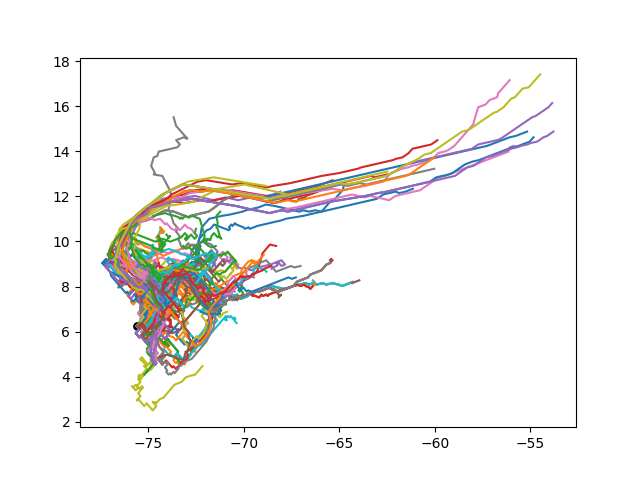

In [42]:
for i in range(116):
    plt.plot(lon_values[i], lat_values[i])
plt.scatter([-75.6], [6.25], c="k", s=28)

In [7]:
xx =xr.open_dataset("/var/meteo/GFS/processed/gfs_0p25_2015032700.nc")
xx

<xarray.Dataset>
Dimensions:        (time: 25, isobaricInhPa: 21, latitude: 201, longitude: 233)
Coordinates:
  * time           (time) datetime64[ns] 2015-03-27 ... 2015-03-30
  * isobaricInhPa  (isobaricInhPa) int64 1000 975 950 925 ... 250 200 150 100
  * latitude       (latitude) float64 20.0 19.75 19.5 ... -29.5 -29.75 -30.0
  * longitude      (longitude) float64 -92.0 -91.75 -91.5 ... -34.5 -34.25 -34.0
Data variables:
    w              (time, isobaricInhPa, latitude, longitude) float32 ...
    t              (time, isobaricInhPa, latitude, longitude) float32 ...
    r              (time, isobaricInhPa, latitude, longitude) float32 ...
    u              (time, isobaricInhPa, latitude, longitude) float32 ...
    v              (time, isobaricInhPa, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.7
    institution:  US National Weather Service - NCEP

In [22]:
%matplotlib notebook